<a href="https://colab.research.google.com/github/k-kotera/my_code/blob/master/shaplets_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 自分用メモ

In [3]:
import tensorflow as tf
import numpy as np
from scipy.io import arff
import matplotlib.pyplot as plt
from keras.utils import to_categorical

Using TensorFlow backend.


In [5]:
import tensorflow.contrib.eager as tfe
 
tf.enable_eager_execution()
 
print("TensorFlow version: {}".format(tf.VERSION))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 1.13.0-rc1
Eager execution: True


In [0]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [6]:
x_train.shape

(60000, 28, 28)

In [0]:
train_dataset, train_meta = arff.loadarff("ECGFiveDays_TRAIN.arff")
test_dataset, test_meta = arff.loadarff("ECGFiveDays_TEST.arff")

trds=np.asarray(train_dataset.tolist(), dtype=np.float32)
Len_data = trds.shape[1]

y_train=np.asarray(trds[:,Len_data-1].tolist(), dtype=np.int16)
X_train=trds[:, :Len_data-1]
teds=np.asarray(test_dataset.tolist(), dtype=np.float32)
y_test=np.asarray(teds[:,Len_data-1].tolist(), dtype=np.int16)
X_test=teds[:, :Len_data-1]

num_classes = len(set(y_train))

y_train_c = to_categorical(y_train-1, num_classes)
y_test_c = to_categorical(y_test-1, num_classes)

In [8]:
X_train.shape

(23, 136)

In [0]:
n_shapelets = 10
alpha = -50
epsilon = 1e-07

x = tf.placeholder(tf.float32, name='x')
#x = tf.convert_to_tensor(X_train)
x_r = tf.reshape(x,[23,136,1])
x_1 = tf.nn.conv1d(x_r, tf.reshape(tf.eye(20),[20,1,20]), stride=1, padding='VALID')

shapelets_kernel = tf.Variable(tf.truncated_normal([n_shapelets, 20], mean=0.0, stddev=0.1))

x_sq = tf.expand_dims(tf.reduce_sum(x_1 ** 2, axis=2), axis=-1)
y_sq = tf.reshape(tf.reduce_sum(shapelets_kernel ** 2, axis=1), (1, 1, n_shapelets))
xy = tf.keras.backend.dot(x_1, tf.transpose(shapelets_kernel))
x_2 = x_sq + y_sq - 2 * xy

#x_3 = tf.reduce_min(x_2,axis = 1)

#softminimum

E = tf.exp(alpha*x_2) + epsilon
x_3 = tf.reduce_sum(x_2*E,axis=1)/tf.reduce_sum(E,axis=1)

w_1 = tf.Variable(tf.zeros([n_shapelets, num_classes]))
b_1 = tf.Variable([0.1] * num_classes)

x_4 = tf.matmul(x_3, w_1) + b_1

y_1 = tf.nn.softmax(x_4)

In [0]:
# 正解ラベルy_train_c
labels = tf.placeholder(tf.float32, name='labels')
# 損失関数（交差エントロピー）と最適化処理（Adam）
loss = tf.losses.softmax_cross_entropy(labels,y_1)
optimizer = tf.train.AdamOptimizer().minimize(loss)

In [0]:
prediction_match = tf.equal(tf.argmax(y_1, axis=1), tf.argmax(labels, axis=1))
accuracy = tf.reduce_mean(tf.cast(prediction_match, tf.float32), name='accuracy')

In [70]:
# 学習の実行
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

for i in range(10):
  my_feed_dict = {x: X_train, labels: y_train_c.astype(float)}
  
  if i % 10 == 0:
    train_accuracy = accuracy.eval(feed_dict=my_feed_dict)
    loss_e = loss.eval(feed_dict=my_feed_dict)
    print('step {:d}, train_accuracy {:.2f}, train_loss {:.2f}'.format(i, train_accuracy, loss_e))
  
  optimizer.run(feed_dict=my_feed_dict)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


step 0, train_accuracy 0.61, train_loss nan


In [49]:
for i in range(5000):
  my_feed_dict = {x: X_train, labels: y_train_c.astype(float)}
  
  if i % 1000 == 0:
    train_accuracy = accuracy.eval(feed_dict=my_feed_dict)
    loss_e = loss.eval(feed_dict=my_feed_dict)
    print('step {:d}, accuracy {:.2f}, loss {:.2f}'.format(i, train_accuracy, loss_e))
  
  optimizer.run(feed_dict=my_feed_dict)

step 0, accuracy 0.96, loss 0.40
step 1000, accuracy 0.96, loss 0.39
step 2000, accuracy 0.96, loss 0.38
step 3000, accuracy 0.96, loss 0.38
step 4000, accuracy 0.96, loss 0.38


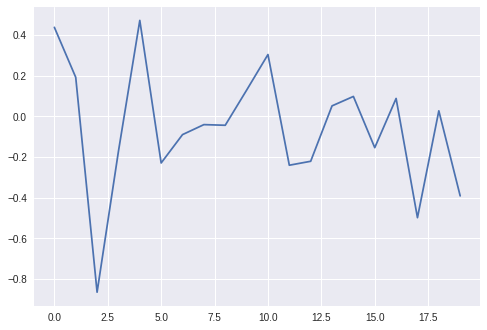

In [58]:
plt.plot(shapelets_kernel.eval()[2])

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd drive/My Drive

/content/drive/My Drive
